# Delaunay triangulation in irregular shapes

1. read the image and flatten it into gray (only for easy computation and less run-time)

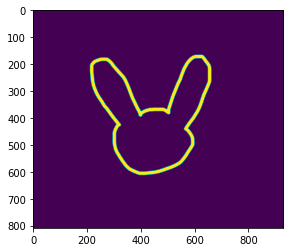

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from skimage import filters
from skimage.color import rgb2hsv, rgb2gray, rgba2rgb

def gray_out_image(image_file):
    image = plt.imread(image_file)
    rgb = rgba2rgb(image)
    image_gray = rgb2gray(rgb)
    return image_gray
gray_image = gray_out_image('rabbit.png')
plt.imshow(gray_image)

2. randomly choose points on the edge of the image 

number of points on edges: 30


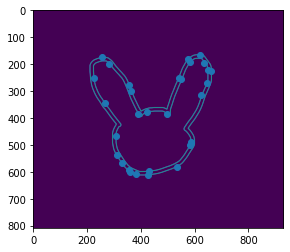

In [2]:
import random
def pick_points(image, num_of_points):
    edge_sobel = filters.sobel(image)
    edge_sobel = np.array(edge_sobel)
    edge_ = []
    for i in range(edge_sobel.shape[0]):
        for j in range(edge_sobel.shape[1]):
            if edge_sobel[i][j] > 1e-10:
                edge_.append((i,j))
    edge_pts = np.array(edge_)
    edge_pts = random.choices(edge_pts, k=num_of_points)
    return np.array(edge_pts)
edge_pts_ = pick_points(gray_image, 30)
print("number of points on edges: " + str(edge_pts_.shape[0])) # pick 30 points

# plot 
edge_sobel_ = filters.sobel(gray_image)
plt.scatter(edge_pts_[:,1],edge_pts_[:,0])
plt.imshow(edge_sobel_)

3. fill the rabbit image with solid color (black) and turn the background into white (so that it is easier to decide whether a point is outside/inside of the image by its color)

total area: 111901


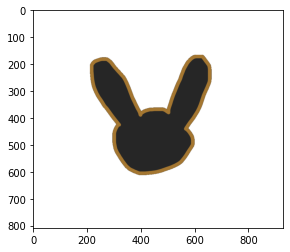

In [3]:
import cv2
#helper function 
def check_not_white(point):
    if (point[0] != 255) and (point[1] != 255) and (point[2] != 255):
        return True
    else:
        return False
def fill_the_image(image):
    img = cv2.imread(image)
    h, w, c = img.shape

    # create zeros mask 2 pixels larger in each dimension
    mask = np.zeros([h + 2, w + 2], np.uint8)

    # do floodfill
    result = img.copy()
    cv2.floodFill(result, mask, (0,0), (255,255,255), (3,151,65), (3,151,65), flags=8)
    
    #calculate the total area
    area = 0
    for i in range(h):
        for j in range(w):
            if check_not_white(result[i][j]):
                area += 1

    return area, result
total_area, decision_image = fill_the_image("rabbit.png")
print("total area: " + str(total_area))
plt.imshow(decision_image)

4. helper functions to get the rounded incenter of a triangle, the middle point of two points, and the triangle area based on the coordinates of vertices

In [4]:
def incenter(pa,pb,pc):
    a = np.sqrt((pb[0]-pc[0])**2+(pb[1]-pc[1])**2)
    b = np.sqrt((pa[0]-pc[0])**2+(pa[1]-pc[1])**2)
    c = np.sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
    peri = a+b+c
    x = (a*pa[0]+b*pb[0]+c*pc[0])/peri
    y = (a*pa[1]+b*pb[1]+c*pc[1])/peri
    return (round(x),round(y))
def middle_points(pa,pb):
    x = (pa[0]+pb[0]) / 2
    y = (pa[1]+pb[1]) / 2
    return (round(x),round(y))
def triangle_area(pa, pb, pc):
    return abs((0.5)*(pa[0]*(pb[1]-pc[1])+pb[0]*(pc[1]-pa[1])+pc[0]*(pa[1]-pb[1])))


5. draw out the points and delaunay triangles (ensure the incenter of each triangle is inside the image and the middle point of each triangle edge is also inside the image ===> try best to cut out triangles which might have an edge outside the image, but it is only an approxiamte way, some not-perfect-insiders might still exists)

number of triangles: 32
area of triangles: 81471.5


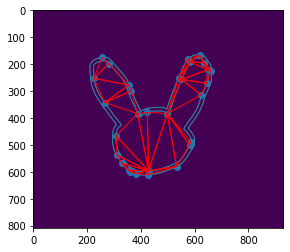

In [5]:
from matplotlib.patches import Polygon

tri = Delaunay(edge_pts_)

def draw_inside_triangles(draw, result, ax, points, vertices, colours=None, **kwargs):
    """
    Draws a set of triangles on axis
    :param draw: if true then draw out the lines
    :param result: the decision image with white pixels as the background
    :param ax: ax
    :param points: array of (x,y) coordinates
    :param vertices: an array of the vertices of the triangles, indexing the array points
    :param colours: colour of the faces, set as none just to plot the outline
    :param kwargs: kwargs passed to Polygon
    :return: area of the triangles
    """
    num_of_triangles = 0
    area_sum_of_triangles = 0
    if colours is None:
        face_colours = len(vertices) * ["none"]
        line_colours = len(vertices) * ["red"]
    else:
        face_colours = colours
        line_colours = colours
    points= np.array(points)
    points= np.flip(points,1)
    for triangle, fc, ec in zip(vertices, face_colours, line_colours):
        (x_,y_) = incenter(points[triangle[0]],points[triangle[1]],points[triangle[2]])
        if check_not_white(result[y_][x_]):
            (x1, y1) = middle_points(points[triangle[0]],points[triangle[1]])
            (x2, y2) = middle_points(points[triangle[1]],points[triangle[2]])
            (x3, y3) = middle_points(points[triangle[0]],points[triangle[2]])
            if ((check_not_white(result[y1][x1])) and (check_not_white(result[y2][x2])) 
                and (check_not_white(result[y3][x3]))):
                if draw:
                    p = Polygon([points[i]
                             for i in triangle],
                            closed=True, facecolor=fc,
                            edgecolor=ec, **kwargs)
                    ax.add_patch(p)
                 
                num_of_triangles += 1
                area_sum_of_triangles += triangle_area(points[triangle[0]],points[triangle[1]],points[triangle[2]])
    return num_of_triangles, area_sum_of_triangles
fig, ax = plt.subplots()
ax.imshow(filters.sobel(gray_image))
ax.scatter(edge_pts_[:,1],edge_pts_[:,0])
num_triangles, area_sum_tri = draw_inside_triangles(True, decision_image, ax, tri.points, tri.vertices)
print("number of triangles: " + str(num_triangles))
print("area of triangles: " + str(area_sum_tri))

In [6]:
error_area = total_area - area_sum_tri
print("error area: " + str(error_area))
print("error in digit: " + str(error_area/total_area))

error area: 30429.5
error in digit: 0.27193233304438746


6. analyze the relationship between (number of triangles) and (error area)

In [7]:
triangle_number = []
error_area_n = []
for num in range(10, 100):
    edge_pts_n = pick_points(gray_image, num)
    tri_n = Delaunay(edge_pts_n)
    num_triangles_n, area_sum_tri_n = draw_inside_triangles(False, decision_image, ax, tri_n.points, tri_n.vertices)
    triangle_number.append(num_triangles_n)
    error_area_n.append(total_area-area_sum_tri_n)
triangle_number = np.array(triangle_number)
error_area_n = np.array(error_area_n)

Text(0, 0.5, 'error area')

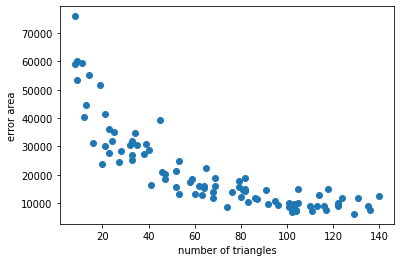

In [8]:
plt.scatter(triangle_number, error_area_n)
plt.xlabel("number of triangles")
plt.ylabel("error area")

[207904.06787971  -9364.27815225]


Text(0, 0.5, 'error area')

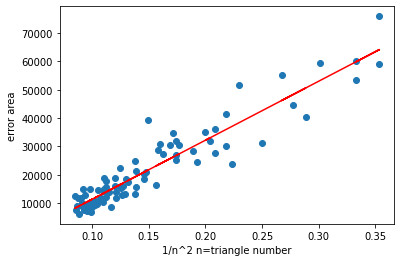

In [9]:
from scipy import optimize
# draw the points
one_over_sqrt_of_n = 1 / np.sqrt(triangle_number)
plt.scatter(one_over_sqrt_of_n, error_area_n)

# fit in the line
def func(x, a, b):
    y = a*x + b
    return y
alpha = optimize.curve_fit(func, xdata = one_over_sqrt_of_n, ydata = error_area_n)[0]
print(alpha)

plt.plot(one_over_sqrt_of_n, alpha[0]*one_over_sqrt_of_n + alpha[1], 'r')

plt.xlabel("1/n^2 n=triangle number")
plt.ylabel("error area")